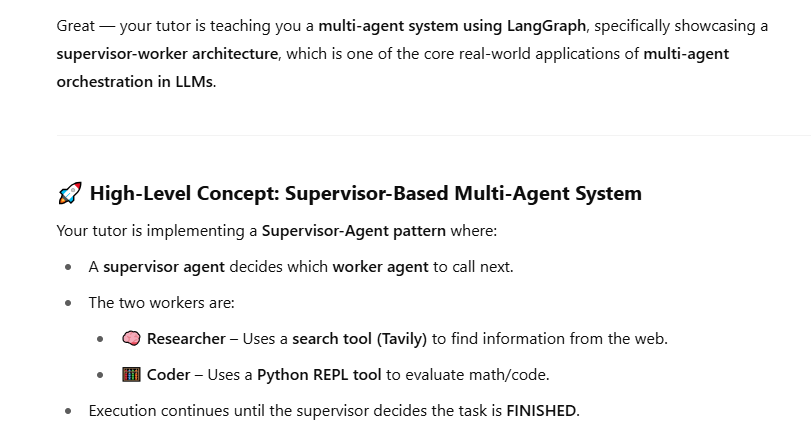

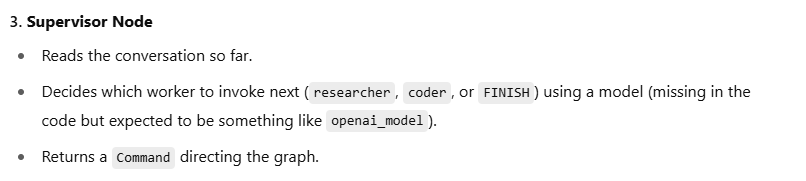

In [1]:
!pip install \
  "langchain" \
  "langchain-community" \
  "langchain-experimental" \
  "langchain-groq" \
  "langgraph" \
  "openmeteo-requests" \
  "requests-cache" \
  "retry-requests" \
  numpy \
  pandas \
  langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB

In [2]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import create_react_agent #create_react_agent: Makes an agent that can use tools and reason step-by-step (ReAct = Reason + Act).

In [25]:
# --- LLM and Tools Setup ---
groq_api_key = "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"

# Use a capable model for tool usage like Mixtral or Llama3
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama3-70b-8192"
)

In [26]:
TAVILY_API_KEY="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"

In [27]:
tavaily_tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [28]:
repl=PythonREPL()

In [29]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."],): # ✅ That text — "The python code to execute to generate your chart." — is just a description used inside the Annotated type hint. It’s not functional code; it’s meant to help tools or documentation generators understand what the argument represents.
  """ use this to execute the python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
  try:
    result=repl.run(code)
  except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
  result_str=f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
  return result_str


In [30]:
members = ["researcher", "coder"]
options = members + ["FINISH"]

In [31]:
class Router(TypedDict):                                                  # class Router(TypedDict)	Defines the expected format of a dictionary,The dictionary must have a key called "next"
  """Worker to route to next. If no workers needed, route to FINISH."""
  next: Literal['researcher', 'coder', 'FINISH']

# This is a dictionary with just one key: next.
# Its value must be one of: "researcher", "coder", "FINISH".

# This is a special type of class used only for defining the shape of a dictionary — not for creating objects with behavior.
# It's called a TypedDict, introduced to help with type checking in tools .

# ✅ What does it do?
# This class defines a dictionary format that must contain one key:
# next, whose value can only be "researcher", "coder", or "FINISH"

In [32]:
class State(MessagesState):
    next:str
# Adds a new field next to track who to call next.
'''
means you're creating a custom data structure (a class) that:
Inherits from MessagesState
Adds one new field called next of type str

So what is happening here?
✅ MessagesState is a predefined base class (from LangGraph)
It typically contains:

A field called messages, which is a list of conversation messages (HumanMessage, AIMessage, etc.)

✅ State is extending that to also include:
A new string field called next, which keeps track of which worker is next (like "coder", "researcher", or "FINISH").
'''

'\nmeans you\'re creating a custom data structure (a class) that:\nInherits from MessagesState\nAdds one new field called next of type str\n\nSo what is happening here?\n✅ MessagesState is a predefined base class (from LangGraph)\nIt typically contains:\n\nA field called messages, which is a list of conversation messages (HumanMessage, AIMessage, etc.)\n\n✅ State is extending that to also include:\nA new string field called next, which keeps track of which worker is next (like "coder", "researcher", or "FINISH").\n'

In [33]:
system_prompt=f"""
You are a supervisor. Given a task, route it to one of the following:\n"
    "- coder: if the task requires Python code or programmatic solution.\n"
    "- researcher: if the task requires information from the web.\n\n"
    "Task: {input}\n"
    "Answer with only one of [coder, researcher].
"""

In [34]:
# This defines a function called supervisor_node.
# It takes state as input. This state holds the conversation so far (messages) and the last selected agent (in next).
# The function will return a Command, which tells LangGraph who to send control to next.
# That next step must be either "researcher", "coder", or "__end__" (which is used to signal FINISH).

def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
  messages = [{"role": "system", "content": system_prompt},] + state["messages"]
  response = llm.with_structured_output(Router).invoke(messages) # This line sends the messages to the LLM (your model).
                                                                 # It expects the response to be a dictionary that follows the shape of the Router class
                                                                 # (i.e., it must have a next key). So the model responds with something like:{"next": "coder"}
  goto = response["next"]
  print("below my goto**********************************")

  print(goto)

  if goto == "FINISH":
      goto = END

  return Command(goto=goto, update={"next": goto})

# 📦 Summary:
# This function acts like a boss (supervisor) who watches what has happened in the chat so far and decides:
# “Now the researcher should respond”
# Or “Now the coder should respond”
# Or “We’re done”

In [35]:
# This defines a function called research_node.
# It takes in the current state (messages + other info).
# It returns a Command that tells LangGraph to  go back to the "supervisor" after it's done.

def research_node(state: State) -> Command[Literal["supervisor"]]:

    research_agent = create_react_agent(llm, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.") # This creates an agent using LangChain’s
                                                                                          # create_react_agent. The agent uses: llm: your language model (like GPT)
                                                                                          # tools=[tavaily_tool]: gives the agent internet search power (Tavily tool)
                                                                                          # A special prompt: "You are a researcher. DO NOT do any math.
                                                                                          # "This tells the agent it should look things up, not do calculations.
    result = research_agent.invoke(state) # state will give 	Full conversation state (messages + next step info), while state["messages"] will give only message
                                          # history, so ideally we need both message history and next info , so state , not state["messages"]

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

    # Extracts the latest reply from the research agent: result["messages"][-1].content
    # Wraps that reply as a HumanMessage with the name "researcher" (to keep track).
    # Updates the state by adding that message.
    # Then sends control back to the "supervisor" node, so it can decide what happens next.



In [36]:
def code_node(state: State) -> Command[Literal["supervisor"]]:

    code_agent = create_react_agent(llm, tools=[python_repl_tool])

    result = code_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [37]:
graph=StateGraph(State)
graph.add_node("supervisor",supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)

graph.add_edge(START,"supervisor")
app=graph.compile()

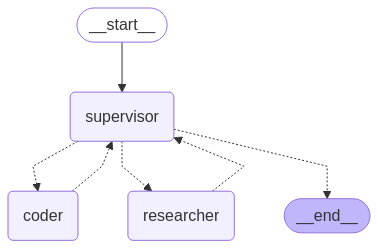

In [38]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [39]:
max_steps = 10
steps = 0

for s in app.stream({"messages": [HumanMessage(content="What's 2 times 135?")]}, subgraphs=True):
    print(s)
    print("----")
    steps += 1
    if steps >= max_steps:
        print("Stopping due to max step limit.")
        break



below my goto**********************************
researcher
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:04d14bfc-3f1e-b12e-3966-e969a8090fd9',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_me9k', 'function': {'arguments': '{"query":"2 times 135"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 961, 'total_tokens': 1001, 'completion_time': 0.139121947, 'prompt_time': 0.032267892, 'queue_time': 0.216354943, 'total_time': 0.171389839}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8bb9bcfc-cbca-4d05-9daf-53ce85507db6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2 times 135'}, 'id': 'call_me9k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 961, 'output_tokens': 40, 'total_tokens': 1001})]}})
----
(('researcher:

# **Your current supervisor_chain probably lacks intelligent routing logic that distinguishes whether a task requires research or code generation.**

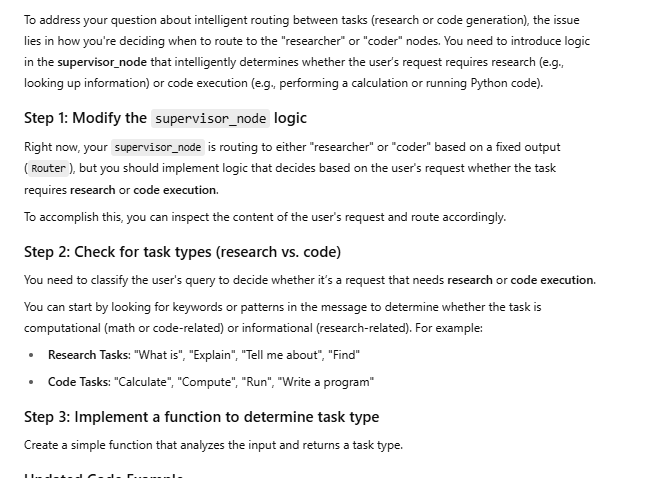

updated code

In [40]:
def determine_task_type(user_request: str) -> Literal['researcher', 'coder']:
    """
    Determines whether the user's request is research-related or code-related.
    """
    code_keywords = ['calculate', 'compute', 'run', 'write', 'program']
    research_keywords = ['what is', 'tell me about', 'explain', 'find']

    user_request = user_request.lower()

    # Check for code-related keywords
    if any(keyword in user_request for keyword in code_keywords):
        return 'coder'

    # Check for research-related keywords
    if any(keyword in user_request for keyword in research_keywords):
        return 'researcher'

    # Default to research if unsure
    return 'researcher'

def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:
    """
    Decides which worker (researcher or coder) should act next based on the user's request.
    """
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    # Assume the user request is the last message
    user_request = state["messages"][-1]["content"]

    # Use the helper function to determine the task type
    task_type = determine_task_type(user_request)

    print(f"Routing to {task_type} based on user request: {user_request}")

    # If the task is to finish, we route to the end
    if task_type == "coder":
        goto = "coder"
    elif task_type == "researcher":
        goto = "researcher"
    else:
        goto = "FINISH"

    return Command(goto=goto, update={"next": goto})
